In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install pytorch interface untuk pre-trained BERT
!pip install transformers

In [3]:
# Libraries import
import torch
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import string
import collections
from transformers import BertTokenizerFast, BertForQuestionAnswering
from transformers.tokenization_utils_base import BatchEncoding
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

pd.set_option('max_colwidth', 500)
%matplotlib inline

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
# Set random seed
seed = 123456
def reset_seed():
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
reset_seed()

In [6]:
# Mendefinisikan model BERT menggunakan pre-trained model dari Hugging Face
BERT_MODEL_NAME = 'bert-base-uncased'

In [7]:
def squad_load_from_json(json_file_path: str):
  with open(json_file_path, "r") as f:
    json_data = json.load(f)['data']
    questions = []
    answers = []
    corpuses = []
    for category in json_data:
      for paragraph in category['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
          corpuses.append(context)
          question = qa['question']
          questions.append(question)
          if qa['is_impossible']:
            ans_list = qa['plausible_answers']
          else:
            ans_list = qa['answers']
          ans_set = set()
          for idx, ans in enumerate(ans_list):
            ans_set.add((ans['answer_start'], ans['answer_start']+len(ans['text']), ans['text']))
          answers.append(list(ans_set))
    return pd.DataFrame(data={'question':questions, 'answer':answers, 'corpus':corpuses})

In [8]:
train_dataset = squad_load_from_json("/content/drive/MyDrive/PBA/dataset_newsqa/newsqa_train.json")
train_dataset = train_dataset[0:20000]

In [9]:
validation_dataset = squad_load_from_json("/content/drive/MyDrive/PBA/dataset_newsqa/newsqa_dev.json")
validation_dataset = validation_dataset[0:1000]

In [10]:
train_dataset = train_dataset.explode('answer').reset_index()
train_dataset

,index,question,answer,corpus
0,0,What was the amount of children murdered ?,"(305, 307, 19)","NEW DELHI , India -LRB- CNN -RRB- -- A high court in northern India on Friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed `` the house of horrors . '' Moninder Singh Pandher was sentenced to death by a lower court in February . The teen was one of 19 victims -- children and young women -- in one of the most gruesome serial killings in India in recent years . The Allahabad high court has acquitted Moninder Singh Pandher , his lawyer Sik..."
1,1,Where was one employee killed ?,"(44, 69, Sudanese region of Darfur)","-LRB- CNN -RRB- -- Fighting in the volatile Sudanese region of Darfur has sparked another wave of refugees into Chad and left a Red Cross employee dead , according to international agencies . Refugee camps in eastern Chad house about 300,000 people who fled violence in the Darfur region of Sudan . The U.N. High Commissioner for Refugees said on Monday that more than 12,000 people have fled militia attacks over the last few days from Sudan 's Darfur region to neighboring Chad , still recoveri..."
2,2,who did say South Africa did not issue a visa on time ?,"(114, 137, Archbishop Desmond Tutu)","Johannesburg -LRB- CNN -RRB- -- Miffed by a visa delay that led the Dalai Lama to cancel a trip to South Africa , Archbishop Desmond Tutu lashed out at his government Tuesday , saying it had acted worse than apartheid regimes and had forgotten all that the nation stood for . `` When we used to apply for passports under the apartheid government , we never knew until the last moment what their decision was , '' Tutu said at a news conference . `` Our government is worse than the apartheid gove..."
3,3,How many years old was the businessman ?,"(540, 551, 29-year-old)",-LRB- CNN -RRB- -- England international footballer Steven Gerrard was found not guilty of affray by a court in his home city on Friday . England international Steven Gerrard was cleared by a court in Liverpool of affray . The jury at Liverpool Crown Court took a little over an hour to clear Gerrard of charges relating to a fracas in a nightclub bar in the north-western of England city on December 29 of last year . They accepted the Liverpool captain 's version that he acted in self defense ...
4,4,What frightened the families ?,"(697, 798, a series of killings and threats by Muslim extremists ordering them to convert to Islam or face death)","BAGHDAD , Iraq -LRB- CNN -RRB- -- At least 6,000 Christians have fled the northern Iraqi city of Mosul in the past week because of killings and death threats , Iraq 's Ministry of Immigration and Displaced Persons said Thursday . A Christian family that fled Mosul found refuge in the Al-Sayida monastery about 30 miles north of the city . The number represents 1,424 families , at least 70 more families than were reported to be displaced on Wednesday . The ministry said it had set up an operat..."
...,...,...,...,...
19995,19995,Which website graded the airlines ?,"(317, 333, FlyersRights.org)","-LRB- CNN -RRB- -- Far too many passengers are being stranded on board commercial flights in the United States in delays , an air passengers ' rights group said Wednesday . Delta Air Lines , JetBlue , Continental Airlines , and US Airways received an overall grade of `` F '' on the air travel consumer report card . FlyersRights.org , in issuing what it calls an air travel consumer report card , said there were more than 1,200 tarmac strandings -- in which passengers are locked in planes on t..."
19996,19996,What height is the tower ?,"(471, 481, 1,000-foot)","-LRB- CNN -RRB- -- Three crew members died in a fiery Navy helicopter crash near Corpus Christi , Texas , a military spokesman said , and a fourth is hospitalized in critical condition . The Navy MH-53 Sea Dragon helicopter crashed in a field about four miles south of Corpus Christi on Wednesday just after 8 p.m. . It caught fire after 

In [11]:
validation_dataset = validation_dataset.explode('answer').reset_index()
validation_dataset

,index,question,answer,corpus
0,0,Iran criticizes who ?,"(75, 108, U.S. President-elect Barack Obama)","TEHRAN , Iran -LRB- CNN -RRB- -- Iran 's parliament speaker has criticized U.S. President-elect Barack Obama for saying that Iran 's development of a nuclear weapon is unacceptable . Iranian President Mahmoud Ahmadinejad has outlined where he thinks U.S. policy needs to change . Ali Larijani said Saturday that Obama should apply his campaign message of change to U.S. dealings with Iran . `` Obama must know that the change that he talks about is not simply a superficial changing of colors or ..."
1,1,What happened to the U.N. compound ?,"(3246, 3265, hit and set on fire)","LONDON , England -LRB- CNN -RRB- -- Israeli military action in Gaza is comparable to that of German soldiers during the Holocaust , a Jewish UK lawmaker whose family suffered at the hands of the Nazis has claimed . A protester confronts police in London last weekend at a demonstration against Israeli action in Gaza . Gerald Kaufman , a member of the UK 's ruling Labour Party , also called for an arms embargo on Israel , currently fighting militant Palestinian group Hamas , during the debate ..."
2,2,Who said there is no immediate plans for deployment ?,"(122, 137, President Obama)","WASHINGTON -LRB- CNN -RRB- -- There are no immediate plans to commit more U.S. troops to the ongoing war in Afghanistan , President Obama said Wednesday . Canadian Prime Minister Stephen Harper , left , and President Obama meet in Washington on Wednesday . Speaking to reporters alongside Canadian Prime Minister Stephen Harper , Obama said he would consult with U.S. allies before determining a strategy in Afghanistan after last month 's elections there . `` I 'm going to take a very deliberat..."
3,3,Will Lieberman investigate further ?,"(1980, 2005, intends to follow up with)","LOS ANGELES , California -LRB- CNN -RRB- -- Former detainees of Immigration and Customs Enforcement accuse the agency in a lawsuit of forcibly injecting them with psychotropic drugs while trying to shuttle them out of the country during their deportation . Raymond Soeoth , pictured here with his wife , says he was injected with drugs by ICE agents against his will . One of the drugs in question is the potent anti-psychotic drug Haldol , which is often used to treat schizophrenia or other men..."
4,4,Who spent nine years in prison ?,"(112, 123, Tim Masters)","-LRB- CNN -RRB- -- A Colorado prosecutor Friday asked a judge to dismiss the first-degree murder charge against Tim Masters , who spent nine years in prison until new DNA evidence indicated someone else might have committed the crime . Tim Masters , center , walks out of a Fort Collins , Colorado , courthouse Tuesday with his attorney David Wymore . Court papers filed by District Attorney Larry Abrahamson cited `` newly discovered '' evidence , but took pains to state that evidence did n't c..."
...,...,...,...,...
995,995,What larger crime organization is mentioned ?,"(154, 159, Mafia)","-LRB- CNN -RRB- -- The Italian government has approved the creation of a new task force of 500 soldiers who will be deployed to combat the recent wave of Mafia crime in the country . The army has been deployed in major cities aross Italy since the early summer . Defense Minister Ignazio La Russa told the ANSA press agency Tuesday that '' the majority '' of the troops would be sent to the southern city of Naples following the worst ever Camorra massacre last week , that left an Italian and si..."
996,996,What items were thrown ?,"(825, 860, Molotov cocktails , rocks and glass)","Cairo -LRB- CNN -RRB- -- Six people were killed and at least 300 were injured when pro-democracy activists clashed Friday with Egyptian security forces in central Cairo , a government official said . Two of the dead were teenagers and one was an Islamic scholar , said Dr. Hisham Shiha , a spokesman for the Ministry of Health . At least four of the fatalities suffered gunshot wounds , with one 

In [12]:
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
def calculate_tokenized_ans_indices(dataset: pd.DataFrame):
  ans_tok_start = []
  ans_tok_end = []
  ans_tok_text = []
  for idx, ans in enumerate(dataset['answer'].values):
    if not pd.isna(ans):
      ans_text_start = ans[0]
      ans_text_end = ans[1]
      ans_text = ans[2]
      encoding = tokenizer.encode_plus(text=dataset['corpus'].values[idx], text_pair=dataset['question'].values[idx], max_length=512, padding='max_length', truncation=True)
      ans_start = encoding.char_to_token(0, ans_text_start)
      ans_end = encoding.char_to_token(0, ans_text_end-1)
      # Τruncated answer
      if ans_start is None:
        ans_start = ans_end = tokenizer.model_max_length
      elif ans_end is None:
        ans_end = [i for i, inp in enumerate(encoding['input_ids']) if inp == tokenizer.sep_token_id][0]
      # else:
      ans_text_tok = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoding['input_ids'][ans_start:ans_end+1]))
      #   if (normalize_answer(ans_text) != normalize_answer(ans_tok_text)):
      #     print(idx, normalize_answer(ans_text), "|||||", normalize_answer(ans_tok_text))
    else:
      ans_start = ans_end = tokenizer.model_max_length
      ans_text_tok = ""
    ans_tok_start.append(ans_start)
    ans_tok_end.append(ans_end)
    ans_tok_text.append(ans_text_tok)
  dataset['ans_start_tok'] = ans_tok_start
  dataset['ans_end_tok'] = ans_tok_end
  dataset['ans_tok_text'] = ans_tok_text
  return dataset

In [14]:
train_dataset = calculate_tokenized_ans_indices(train_dataset)
train_dataset

,index,question,answer,corpus,ans_start_tok,ans_end_tok,ans_tok_text
0,0,What was the amount of children murdered ?,"(305, 307, 19)","NEW DELHI , India -LRB- CNN -RRB- -- A high court in northern India on Friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed `` the house of horrors . '' Moninder Singh Pandher was sentenced to death by a lower court in February . The teen was one of 19 victims -- children and young women -- in one of the most gruesome serial killings in India in recent years . The Allahabad high court has acquitted Moninder Singh Pandher , his lawyer Sik...",74,74,19
1,1,Where was one employee killed ?,"(44, 69, Sudanese region of Darfur)","-LRB- CNN -RRB- -- Fighting in the volatile Sudanese region of Darfur has sparked another wave of refugees into Chad and left a Red Cross employee dead , according to international agencies . Refugee camps in eastern Chad house about 300,000 people who fled violence in the Darfur region of Sudan . The U.N. High Commissioner for Refugees said on Monday that more than 12,000 people have fled militia attacks over the last few days from Sudan 's Darfur region to neighboring Chad , still recoveri...",16,20,sudanese region of darfur
2,2,who did say South Africa did not issue a visa on time ?,"(114, 137, Archbishop Desmond Tutu)","Johannesburg -LRB- CNN -RRB- -- Miffed by a visa delay that led the Dalai Lama to cancel a trip to South Africa , Archbishop Desmond Tutu lashed out at his government Tuesday , saying it had acted worse than apartheid regimes and had forgotten all that the nation stood for . `` When we used to apply for passports under the apartheid government , we never knew until the last moment what their decision was , '' Tutu said at a news conference . `` Our government is worse than the apartheid gove...",32,35,archbishop desmond tutu
3,3,How many years old was the businessman ?,"(540, 551, 29-year-old)",-LRB- CNN -RRB- -- England international footballer Steven Gerrard was found not guilty of affray by a court in his home city on Friday . England international Steven Gerrard was cleared by a court in Liverpool of affray . The jury at Liverpool Crown Court took a little over an hour to clear Gerrard of charges relating to a fracas in a nightclub bar in the north-western of England city on December 29 of last year . They accepted the Liverpool captain 's version that he acted in self defense ...,118,122,29 - year - old
4,4,What frightened the families ?,"(697, 798, a series of killings and threats by Muslim extremists ordering them to convert to Islam or face death)","BAGHDAD , Iraq -LRB- CNN -RRB- -- At least 6,000 Christians have fled the northern Iraqi city of Mosul in the past week because of killings and death threats , Iraq 's Ministry of Immigration and Displaced Persons said Thursday . A Christian family that fled Mosul found refuge in the Al-Sayida monastery about 30 miles north of the city . The number represents 1,424 families , at least 70 more families than were reported to be displaced on Wednesday . The ministry said it had set up an operat...",146,166,a series of killings and threats by muslim extremists ordering them to convert to islam or face death
...,...,...,...,...,...,...,...
19995,19995,Which website graded the airlines ?,"(317, 333, FlyersRights.org)","-LRB- CNN -RRB- -- Far too many passengers are being stranded on board commercial flights in the United States in delays , an air passengers ' rights group said Wednesday . Delta Air Lines , JetBlue , Continental Airlines , and US Airways received an overall grade of `` F '' on the air travel consumer report card . FlyersRights.org , in issuing what it calls an air travel consumer report card , said there were more than 1,200 tarmac strandings -- in which passengers are locked in planes on t...",71,75,flyersrights. org
19996,19996,What height is the tower ?,"(471, 481, 1,000-foot)","-LRB- CNN -RRB- -- Three crew members died in a fiery Navy

In [15]:
validation_dataset = calculate_tokenized_ans_indices(validation_dataset)
validation_dataset

,index,question,answer,corpus,ans_start_tok,ans_end_tok,ans_tok_text
0,0,Iran criticizes who ?,"(75, 108, U.S. President-elect Barack Obama)","TEHRAN , Iran -LRB- CNN -RRB- -- Iran 's parliament speaker has criticized U.S. President-elect Barack Obama for saying that Iran 's development of a nuclear weapon is unacceptable . Iranian President Mahmoud Ahmadinejad has outlined where he thinks U.S. policy needs to change . Ali Larijani said Saturday that Obama should apply his campaign message of change to U.S. dealings with Iran . `` Obama must know that the change that he talks about is not simply a superficial changing of colors or ...",22,30,u. s. president - elect barack obama
1,1,What happened to the U.N. compound ?,"(3246, 3265, hit and set on fire)","LONDON , England -LRB- CNN -RRB- -- Israeli military action in Gaza is comparable to that of German soldiers during the Holocaust , a Jewish UK lawmaker whose family suffered at the hands of the Nazis has claimed . A protester confronts police in London last weekend at a demonstration against Israeli action in Gaza . Gerald Kaufman , a member of the UK 's ruling Labour Party , also called for an arms embargo on Israel , currently fighting militant Palestinian group Hamas , during the debate ...",512,512,
2,2,Who said there is no immediate plans for deployment ?,"(122, 137, President Obama)","WASHINGTON -LRB- CNN -RRB- -- There are no immediate plans to commit more U.S. troops to the ongoing war in Afghanistan , President Obama said Wednesday . Canadian Prime Minister Stephen Harper , left , and President Obama meet in Washington on Wednesday . Speaking to reporters alongside Canadian Prime Minister Stephen Harper , Obama said he would consult with U.S. allies before determining a strategy in Afghanistan after last month 's elections there . `` I 'm going to take a very deliberat...",33,34,president obama
3,3,Will Lieberman investigate further ?,"(1980, 2005, intends to follow up with)","LOS ANGELES , California -LRB- CNN -RRB- -- Former detainees of Immigration and Customs Enforcement accuse the agency in a lawsuit of forcibly injecting them with psychotropic drugs while trying to shuttle them out of the country during their deportation . Raymond Soeoth , pictured here with his wife , says he was injected with drugs by ICE agents against his will . One of the drugs in question is the potent anti-psychotic drug Haldol , which is often used to treat schizophrenia or other men...",404,408,intends to follow up with
4,4,Who spent nine years in prison ?,"(112, 123, Tim Masters)","-LRB- CNN -RRB- -- A Colorado prosecutor Friday asked a judge to dismiss the first-degree murder charge against Tim Masters , who spent nine years in prison until new DNA evidence indicated someone else might have committed the crime . Tim Masters , center , walks out of a Fort Collins , Colorado , courthouse Tuesday with his attorney David Wymore . Court papers filed by District Attorney Larry Abrahamson cited `` newly discovered '' evidence , but took pains to state that evidence did n't c...",28,29,tim masters
...,...,...,...,...,...,...,...
995,995,What larger crime organization is mentioned ?,"(154, 159, Mafia)","-LRB- CNN -RRB- -- The Italian government has approved the creation of a new task force of 500 soldiers who will be deployed to combat the recent wave of Mafia crime in the country . The army has been deployed in major cities aross Italy since the early summer . Defense Minister Ignazio La Russa told the ANSA press agency Tuesday that '' the majority '' of the troops would be sent to the southern city of Naples following the worst ever Camorra massacre last week , that left an Italian and si...",37,37,mafia
996,996,What items were thrown ?,"(825, 860, Molotov cocktails , rocks and glass)","Cairo -LRB- CNN -RRB- -- Six people were killed and at least 300 were injured when pro-democracy activists clashed Friday with Egyptian security forces in central Cairo , a government official said . Two of 

In [16]:
class NewsQA_Dataset(Dataset):
  def __init__(self, data: pd.DataFrame):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    encoding = tokenizer(text=self.data['corpus'].values[idx], text_pair=self.data['question'].values[idx], max_length=512, padding='max_length', truncation=True, return_tensors='pt').to(device)
    return {
        'ans_start_tok': torch.tensor(self.data['ans_start_tok'].values[idx], dtype=torch.long, device = device),
        'ans_end_tok': torch.tensor(self.data['ans_end_tok'].values[idx], dtype=torch.long, device = device),
        'input_ids': encoding['input_ids'][0],
        'attention_mask': encoding['attention_mask'][0],
        'token_type_ids': encoding['token_type_ids'][0]
    }

In [17]:
train_squad_dataset = NewsQA_Dataset(data=train_dataset)

In [18]:
val_squad_dataset = NewsQA_Dataset(data=validation_dataset)

In [19]:
BATCH_SIZE=8

In [20]:
train_dataloader = DataLoader(train_squad_dataset, batch_size=BATCH_SIZE, shuffle=False)
validation_dataloader = DataLoader(val_squad_dataset, batch_size=1, shuffle=False)

In [21]:
def train(model: BertForQuestionAnswering, train_dataloader: DataLoader, validation_dataloader: DataLoader, learning_rate: float, epochs: int):
  # Define the optimizer
  opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
  # Initialize train and validation losses lists
  train_losses = []
  validation_losses = []
  # Train for given # of epochs
  for epoch in range(epochs):
    model.train()
    t_losses = []
    for batch in tqdm(train_dataloader):
      # Delete previously stored gradients
      opt.zero_grad()
      # Get loss and outputs from the model
      start_positions = batch['ans_start_tok'] # we can do this because we know taht squad trai dataset questions always have 1 question
      end_positions = batch['ans_end_tok']
      out = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], token_type_ids=batch['token_type_ids'], start_positions=start_positions, end_positions=end_positions)
      # Perform backpropagation starting from the loss returned in this epoch
      loss = out[0]
      loss.backward()
      # Update model's weights based on the gradients calculated during backprop
      opt.step()
      t_losses.append(loss.item())

    # Calculate train loss in current epoch
    train_loss = np.mean(t_losses)
    train_losses.append(train_loss)
    with torch.no_grad():
      model.eval()
      v_losses = []
      tmp_losses = []
      cur_idx = -1
      for val_idx, val_batch in enumerate(tqdm(validation_dataloader)):
        start_positions = val_batch['ans_start_tok'] # we can do this because we know taht squad trai dataset questions always have 1 question
        end_positions = val_batch['ans_end_tok']
        out = model(input_ids=val_batch['input_ids'], attention_mask=val_batch['attention_mask'], token_type_ids=val_batch['token_type_ids'], start_positions=start_positions, end_positions=end_positions)
        loss = out[0]
        batch_idx = validation_dataset['index'].values[val_idx]
        if cur_idx != batch_idx:
          cur_idx = batch_idx
          if len(tmp_losses) > 0:
            v_losses.append(min(tmp_losses))
          tmp_losses = []
        tmp_losses.append(loss.item())
      if len(tmp_losses) > 0:
        v_losses.append(min(tmp_losses))
      val_loss = np.mean(v_losses)
      validation_losses.append(val_loss)

    # Print current epoch status
    print(f"Epoch {epoch:3}: Loss = {train_loss:.5f} Val_loss = {val_loss:.5f}")

  return train_losses, validation_losses

In [22]:
def plot_loss_vs_epochs(train_losses, val_losses):
  assert(len(train_losses) == len(val_losses))
  plt.grid()
  plt.plot(list(range(len(train_losses))), train_losses, "o-", label="Train")
  plt.plot(list(range(len(train_losses))), val_losses, "o-", label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [23]:
reset_seed()

In [24]:
model = BertForQuestionAnswering.from_pretrained(BERT_MODEL_NAME).to(device)
model

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [25]:
train_losses, validation_losses = train(model, train_dataloader, validation_dataloader, learning_rate=1e-5, epochs=3)

100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


Epoch   0: Loss = 2.93953 Val_loss = nan


100%|██████████| 1000/1000 [02:55<00:00,  5.70it/s]


Epoch   1: Loss = 1.94692 Val_loss = nan


100%|██████████| 1000/1000 [03:03<00:00,  5.44it/s]

Epoch   2: Loss = 1.47299 Val_loss = nan


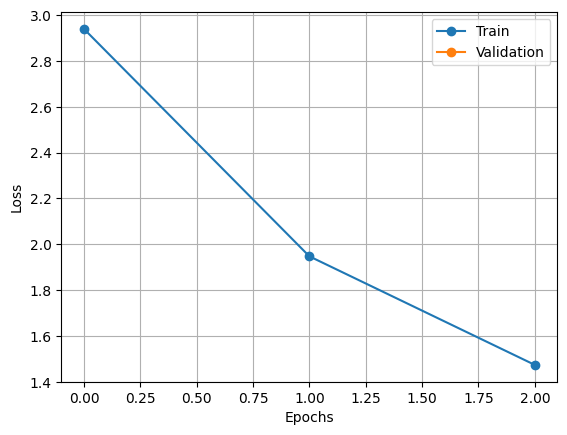

In [26]:
plot_loss_vs_epochs(train_losses, validation_losses)

In [27]:
torch.save(model.state_dict(), "/content/drive/MyDrive/PBA/model.pt")